TP 2 - Echantillonnage compressif
==================

In [3]:
import numpy as np
import numpy.linalg as npl
import math
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn")
mpl.rcParams['figure.dpi'] = 100

Récemment (début années 2004-présent), de nouveaux concepts et théorèmes ont été développés et risquent de 
révolutionner à relativement court terme la fabrication de certains appareils de mesure numériques (microphones, imageurs, analyseurs de spectres,...). 
Ces nouvelles techniques sont couramment appelées échantillonnage compressif, "compressive sampling" ou encore "compressed sensing". 

## 1. Le théorème de Shannon

Aujourd'hui, presque tous les appareils de mesure reposent sur le théorème de Shannon. Celui-ci (vous l'avez déjà vu en 2ème année) peut s'énoncer ainsi : 
> Soit $g:\mathbb{R}\to \mathbb{R}$ une fonction de $L^2(\mathbb{R})$. Si sa transformée de Fourier $\hat g$ a un support contenu dans l'intervalle $[-f_M, f_M]$, alors en l'échantillonnant à une fréquence d'échantillonnage $f_e\geq 2f_M$, on peut la reconstruire exactement.

Ce théorème est illustré sur les figures ci-après:
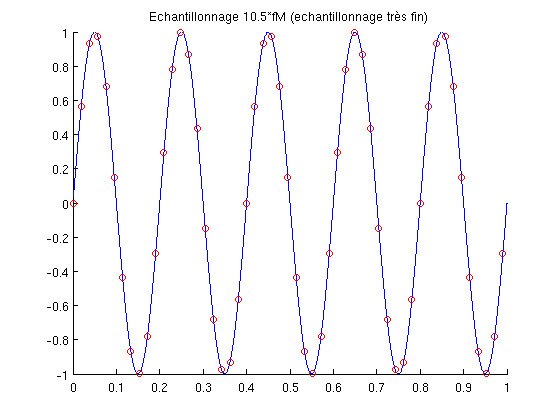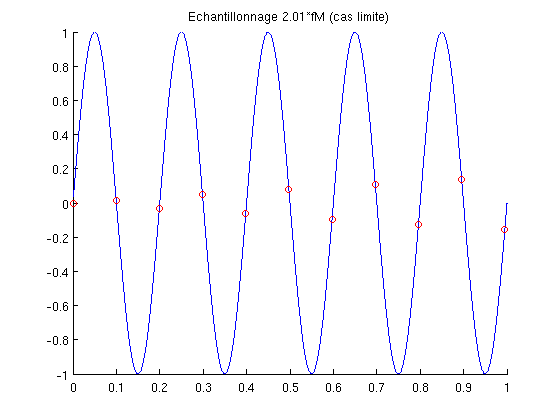
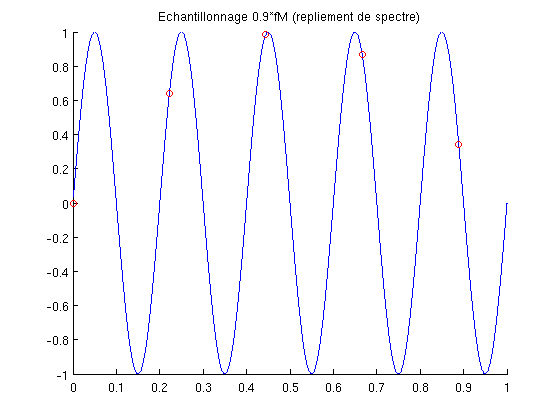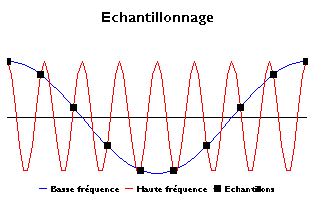

Les instruments de mesures qui reposent sur ce théorème sont donc construits suivant le principe : 
>Filtre passe-bas $\rightarrow$ Echantillonnage à une fréquence $f>2f_M$ $\rightarrow$ Interpolation sinc

Pour beaucoup d'applications, ce principe présente deux défauts majeurs :
* Les signaux sont rarement naturellement à spectre borné, et on perd donc l'information haute-fréquence en effectuant un filtrage passe-bas.
* Pour beaucoup de signaux, il faut choisir une très haute fréquence d'échantillonnage pour obtenir un résultat satisfaisant. 
Ceci implique que les données à stocker ont une taille très importante et qu'il faut les compresser après coup (par exemple : jpeg).




## 2. L'échantillonnage compressif

**1. Principe général**

L'idée sous jacente à l'échantillonnage compressif est de réaliser la compression dès l'acquisition.
Supposons que le signal $x\in \mathbb{R}^n$ que l'on souhaite mesurer s'écrive comme une combinaison linéaire de la forme :
\begin{equation}
(1)~~~~~~~~~~~ x=\sum_{i=1}^m\alpha_i \psi_i
\end{equation}
où $\psi_i\in \mathbb{R}^n, \ i=1..m$, sont des "fonctions de base" (en traitement d'images, ces fonctions pourraient être des ondelettes, en traitement du son, des ondelettes ou des atomes de Fourier, pour certaines applications, on pourrait imaginer des splines...} et $\alpha_i\in \mathbb{R}$ sont des coefficients. 
On peut réécrire l'équation (1) sous la forme matricielle condensée :
$$
x=\Psi \alpha \ \ \textrm{où } \ \ \alpha=\begin{pmatrix} \alpha_1 \\ \vdots \\ \alpha_m \end{pmatrix}\ \ \textrm{et} \ \ \Psi=\begin{pmatrix} \psi_1,\psi_2,..., \psi_m\end{pmatrix}.
$$
Pour pouvoir reconstruire tous les éléments de $\mathbb{R}^n$, on suppose généralement que la matrice $\Psi$ est une matrice surjective (ainsi, la famille  des $(\Psi_i)_i$ est génératrice), ce qui implique que $m\geq n$. Dans le langage du traitement d'image, on dit alors que $\Psi$ est un frame (une base si $m=n$).

L'échantillonnage compressif repose sur l'hypothèse suivante : les signaux $x$ que l'on souhaite mesurer sont parcimonieux, 
c'est-à-dire que la majorité des coefficients $\alpha_i$ dans (1) sont nuls ou encore que 
$$\#\{\alpha_i\neq 0, i=1..m\}\ll n.$$
On va voir que cette hypothèse permet - dans certains cas - de réduire drastiquement le nombre de mesures par rapport au théorème de Shannon avec en contre-partie, le besoin de résoudre un problème d'optimisation pour reconstruire la donnée. L'objectif de ce TP est de résoudre le problème d'optimisation résultant.

Le principe de l'acquisition du signal $x$ est le suivant :

- On effectue un petit nombre $p\ll n$ de mesures linéaires du signal $x$ inconnu. On note ces mesures $y_i$, et comme elles sont linéaires par rapport à $x$, il existe pour chaque $i$ un vecteur $a_i\in \mathbb{R}^n$ tel que 
$$y_i=\langle a_i, x\rangle, i=1..p.$$ On peut aussi écrire cette opération de mesure sous la forme condensée :
$$
y=Ax\ \ \textrm{où } \ \ y=\begin{pmatrix} y_1 \\ \vdots \\ y_p\end{pmatrix} \ \ \textrm{et} \ \ A=\begin{pmatrix} a_1^T\\a_2^T\\ \vdots
\\ a_p^T\end{pmatrix}.
$$
- On reconstruit le signal $x$ en résolvant le problème contraint suivant :

$$
(2)~~~~~~~~~~~ \mbox{Trouver } \alpha^\star \mbox{ solution de: }\displaystyle\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_0
$$

où $\|\cdot\|_0$ est la norme de comptage, aussi appelée norme $l^0$ définie par : 
$$
\|\alpha\|_0=\#\{\alpha_i\neq 0, i=1..m\}.
$$
Autrement dit, l'idée est la suivante : on  cherche $\alpha^\star$, le signal le plus parcimonieux dans le frame $\Psi$, parmi les signaux qui peuvent donner lieu aux mesures $y$. 
Après avoir trouvé $\alpha^\star$, on recouvre $\tilde x$, une approximation du signal $x$ en calculant $\tilde x=\Psi\alpha^\star$.



**2. Simplification du problème d'optimisation**

Le problème précédent est un problème combinatoire NP-complet, ce qui signifie que trouver $\alpha$ peut demander un temps exponentiel en fonction de $n$, la dimension du signal. Pour le résoudre en pratique, il est souvent remplacé par : 

$$
(3)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \displaystyle\arg\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_1
$$

où $\|\alpha\|_1=\sum_{i=1}^m|\alpha_i|$ est la norme $l^1$ de $\alpha$. On peut dans certains cas montrer que les solutions de (2) et de (3) sont identiques. 

Un appareil de mesure n'étant jamais parfait, il est impossible de mesurer exactement $y_i=\langle a_i, x\rangle$. 
Le vecteur $y$ est bruité et la contrainte $A\Psi\alpha=y$ est trop forte. Elle est donc généralement relaxée et le problème devient : 

>$$(4)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \arg\min_{\alpha \in \mathbb{R}^m} \|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.$$

Si $\sigma$ tend vers $0$, la solution du problème (4) tend vers une solution du problème (3). C'est le problème (4) que nous allons résoudre dans ce TP. Dans la suite , on notera $F$ la fonction :
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

Pour conclure cette introduction à l'échantillonnage compressif, notons que de façon similaire au théorème de Shannon, on dispose d'une condition de reconstruction exacte :

> Supposons que :
* $x=\displaystyle\sum_{i=1}^m\alpha_i\psi_i\in \mathbb{R}^n$ avec $\|\alpha\|_0=k$.
* On effectue $p$ mesures linéaires de $x$ avec $p\geq C \cdot k \cdot \log(n)$, où $C=20$.
* On choisit les coefficients de la matrice $A\in \mathcal{M}_{p,n}$ de façon **aléatoire** (e.g. on peut choisir les coefficients $a_{i,j}$ de $A$ de façon indépendante suivant une loi normale.)

> Alors, la résolution du problème (3) permet de reconstruire $x$ **exactement** avec une très grande probabilité 

L'expérience a montré qu'en pratique, il suffit en général de $p=2k$ mesures pour reconstruire le signal exactement en grande dimension !

3. Préliminaires théoriques
----------------------------

Commençons par remarquer que les problèmes (3) et (4) sont convexes (contraintes convexes et fonctions convexes) tandis que le problème (2) ne l'est pas. En revanche, aucun des trois problèmes n'est différentiable.

**Q1.** Soit $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$. Calculez $\nabla J(\alpha)$.
$$
\ast~\ast~\ast
$$
Par développement limité : Soit $h \in \mathbb{R}^m$ 
$J(\alpha + h ) =\frac{\sigma}{2}\|A\Psi \alpha - y + A\Psi h\|_2^2 = J(\alpha) + \sigma\langle A\Psi \alpha - y, A\Psi h \rangle + o(h) = J(\alpha) + \sigma\langle (A\Psi)^t A\Psi \alpha - y, h \rangle + o(h)$

Par définition on a que :  $\nabla J(\alpha) = \sigma (A\Psi)^t (A\Psi \alpha - y)$
$$
\ast~\ast~\ast
$$

L = 2 * sigma * npl.norm(A)**2

**Q2.** Montrer que la fonction $J$ est de classe $C^1$ à gradient Lipschitz et calculer un majorant $L$ de la constante de Lipschitz de $\nabla J$ en fonction de $|||A|||$, de $|||\Psi |||$ et de $\sigma$.
$$
\ast~\ast~\ast
$$

$$\|\nabla J(\alpha) - \nabla J(\beta) \| = \| \sigma (A\Psi)^tA\Psi(\alpha - \beta)\| \leq |\sigma| |||A|||^2 (\Psi^t\Psi) \|\alpha - \beta\|$$
Or $\Psi^t\Psi = 2I$ Par construction, car $\Psi$ est une matrice constituée de fonctions de bases. Dans notre cas on considère 2 bases différentes d'où le facteur 2. Donc on en déduit le majorant $L$ de la constante de Lipschitz de $\nabla J$ :
$$
L = 2  \sigma  |||A|||^2
$$
$$
\ast~\ast~\ast
$$


**Construction de l'algorithme**

On note $\alpha^k$ l'itéré courant. En appliquant le lemme de Nesterov à la fonction $J$, on a:
$$\forall \alpha\in \mathbb{R}^m,~J(\alpha)\leq {J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2}.
$$

En posant $\phi(\alpha,\alpha^k)=J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1$, on a alors:

$$\forall \alpha\in \mathbb{R}^m,~F(\alpha) = J(\alpha)+\|\alpha\|_1\leq \phi(\alpha,\alpha^k),$$

avec : $\phi(\alpha^k,\alpha^k) = F(\alpha^k)$.

Cette inégalité motive alors l'algorithme de descente suivant:

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k).$$

$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$


**Q3.** Montrer que l'algorithme s'écrit de façon équivalente sous la forme:
$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$

\begin{align}
\alpha^{k+1} &= \displaystyle\arg\min_{u\in \mathbb{R}^m} \frac{1}{L} \|u\| + \frac{1}{2} \|u - (\alpha^k - \frac{1}{L}\nabla J(\alpha^k))\| \\
&= \displaystyle\arg\min_{u\in \mathbb{R}^m} \frac{1}{L} \|u\| + \frac{1}{2} \|u - \alpha^k\|^2 + \frac{1}{L}\langle u - \alpha_k, \nabla J(\alpha^k)\rangle + \frac{1}{L^2}\|\nabla J(\alpha^k)\|^2  \\
&= \displaystyle\arg\min_{u\in \mathbb{R}^m}\|u\| + \frac{L}{2} \|u - \alpha^k\|^2 + \langle u - \alpha_k, \nabla J(\alpha^k)\rangle   \\
&= \displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k)
\end{align}

L'avant dernière égalité vient du fait que par la multiplication ou l'ajout d'une constante à une fonction, on ne change pas son argmin.

**Q4.** En déduire la formule analytique donnant $\alpha^{k+1}$ en fonction de $\alpha^k$.

$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$

Or on rappel que : 
$$
\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}(x) = \left(\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}(x_1),\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}(x_2),...,\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}(x_n)\right)
$$
Et 
$$
\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}(x_i) = sign(x_i)max(|x_i| - \frac{1}{L}, 0)
$$
D'où
$$
\alpha^{k+1} = sign\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right)max\left(|\alpha^k - \frac{1}{L}\nabla J(\alpha^k)| - \frac{1}{L}, 0\right)
$$

**Q5.** De quelle quantité la fonction coût $F(\alpha)$ décroît-elle à chaque itération ?

4. Partie expérimentale
------------------------

Dans ce TP, on va chercher à reconstruire un signal unidimensionnel $x~:~[0,1]~\rightarrow~\mathbb{R}$ de la forme :
$$
x(t)= \alpha_{k}\delta_{k/n}(t)+\sum_{k=1}^n\alpha_{k+n}\cos\left(\frac{2k\pi}{n} t\right)
$$ 
on a donc $m=2n$.

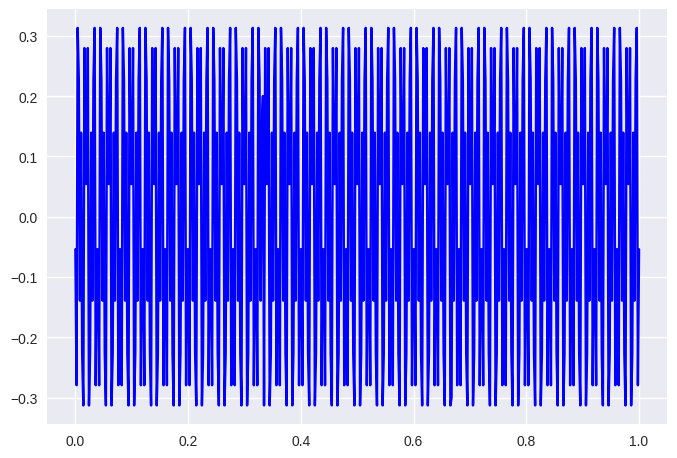

In [2]:
## Initialisations
n=500            #Taille de l'echantillon
t=np.linspace(0,1,n) #On definit un signal sur [0,1]

## Generation du signal
x=np.zeros(n)
tmp=np.zeros(n)
#On ajoute deux cosinus
tmp[350]=4
x+=fft.idct(tmp,norm='ortho')  
tmp=np.zeros(n)
tmp[150]=-3  
x+=fft.idct(tmp,norm='ortho')
#On ajoute deux diracs
x[int(n/3)]=0.2;    #Tester 0.5
x[int(2*n/3)]=-0.3; #Tester -1

plt.plot(t,x,'b')
plt.show()
## Mesure du signal
p = 100
A=np.random.randn(p,n) #La matrice de mesure
y=A.dot(x)        #Les mesures

Le code *Generesignal.py* génère un signal discret $x$ qui peut être vu comme une combinaison linéaire de cosinus à différentes fréquences et de diracs. Ce signal n'est pas parcimonieux dans la base canonique des diracs (car il faut à peu près $n$ diracs pour représenter un cosinus) et il n'est pas parcimonieux dans la base des sinus (il faut faire une combinaison linéaire de $n$ cosinus pour représenter un dirac).

Par contre, ce signal est parcimonieux dans un frame qui est l'union de la base canonique et de la base des cosinus. 
Dans ce frame, il suffit en effet de $4$ coefficients non nuls pour reconstruire parfaitement le signal.

> On choisira donc le frame représenté par une matrice $\Psi=(I,C) \in \mathcal{ M}_{n,2n}(\mathbb{R})$ o\`u $C$ est une base de cosinus à différentes fréquences.

### 4.1. Implémentation de l'itération proximale

**Q6** Implémentez l'opérateur linéaire $\Psi$ et son adjoint $\Psi^*$. 

Pour $\Psi$, vous vous servirez de la fonction $dct$ de Python dans la libraire scipy.fftpack qui calcule la transformée en cosinus discret d'un vecteur. Vous ferez attention à préciser *norm='ortho'* dans les options de la $dct$ pour que $idct$ soit bien l'opération inverse de $dct$.

Pour $\Psi^*$, vous utiliserez le fait que la $dct$ est une isométrie quand on précise \textit{norm='ortho'} dans les options de $dct$.

In [4]:
## Linear function Psi
## (combination of sines and diracs) 
def Psi(alpha) :
    return alpha[:n] + fft.idct(alpha[n:], norm='ortho')


## The transpose of Psi
def PsiT(x) : 
    n = len(x)
    alpha = np.zeros(2 * n)
    alpha[:n] = x
    alpha[n:] = fft.dct(x, norm='ortho') 
    return alpha

**Q7** Implémentez l'algorithme proximal dans la fonction *RestoreX* avec les notations suivantes:
* $A$ est la matrice d'échantillonnage.
* $y$ est le vecteur de mesures.
* $sigma$ est un paramètre du modèle.
* $nit$ est le nombre d'itérations.
* $alpha$ est la solution approximative du problème (4).
* $x$ est donné par Psi $(\alpha)$.
* $CF$ est la fonction coût à chaque itération de l'algorithme. 

In [5]:
## Prox of the l1−norm 
def prox(alpha,gamma) :
    return np.sign(alpha) * np.maximum(np.abs(alpha) - gamma,0)

def J(A,alpha,y,sigma):
    return (sigma / 2) * npl.norm(A @ Psi(alpha) - y, 2)**2

def gradJ(alpha,sigma,A,y):
    return  sigma * PsiT(A.T @ (A.dot(Psi(alpha)) - y))

def RestoreX(A,y,sigma,nitermax, seuil): 
    p,n = np.shape(A)
    alpha = np.random.rand(2 * n)
    L = 2 * sigma * npl.norm(A)**2
    CF = []
    err = [1]
    xtilde = np.random.rand(n)
    k = 0 
    while k < nitermax and err[k] > seuil:
        gJ = gradJ(alpha,sigma,A,y)
        alpha = prox(alpha - (1/L) * gJ,1 / L)
        x_prev = np.copy(xtilde)
        xtilde = Psi(alpha)
        CF.append(J(A,alpha,y,sigma) + npl.norm(alpha,1)) 
        err.append(npl.norm(x_prev - xtilde))
        k+=1
    return (alpha,xtilde,CF,err)


**Q8.** Testez votre algorithme ! Les paramètres $sigma$ et $nit$ sont des à choisir par vous-même (il faut en pratique beaucoup d'itérations pour converger). Vous pourrez observer la façon dont la suite $\alpha^k$ se comporte au fur et à mesure des itérations.

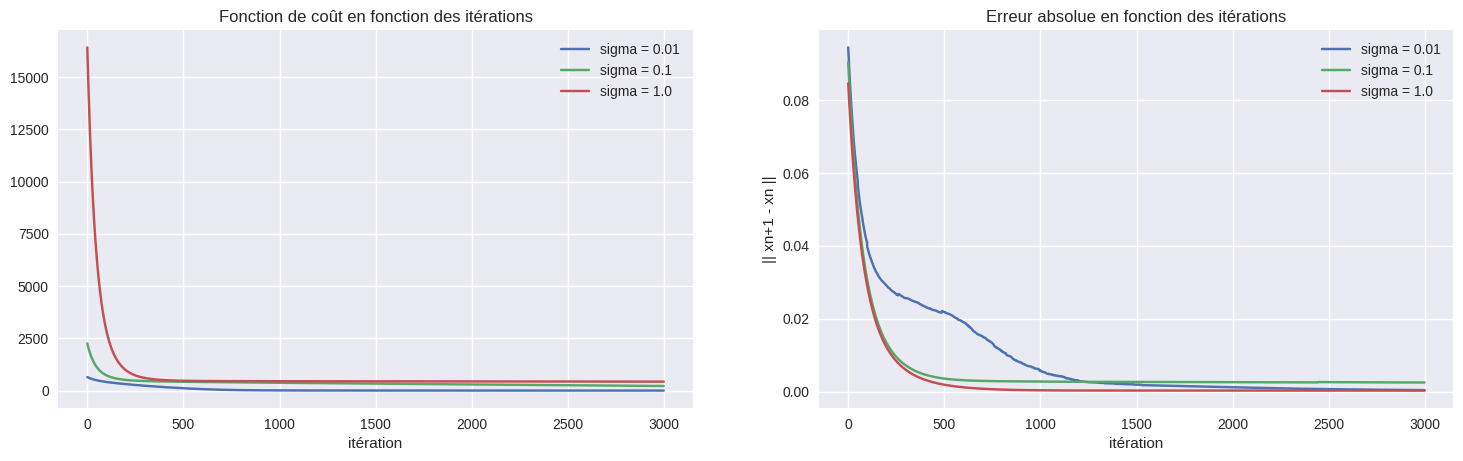

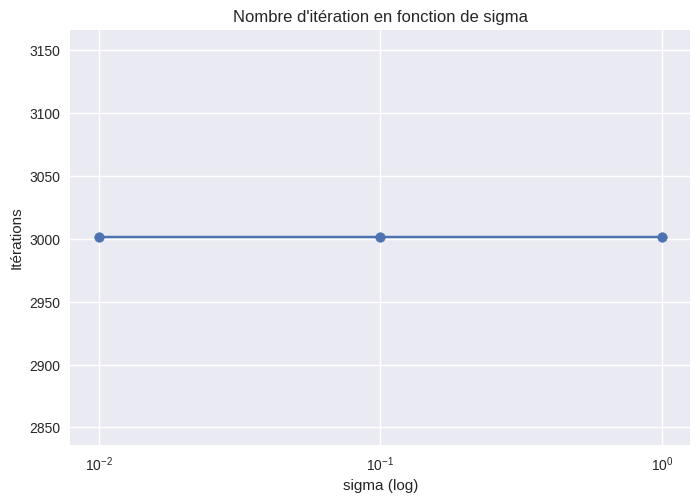

In [9]:
nitermax=3000
fig,ax = plt.subplots(1,2, figsize=(18,5))
nit = [] # Tableau du nombre d'itérations par valeur du paramètre sigma
testData = [10.**k for k in np.arange(-2,1,1)]
for sigma in testData:
    (alpha,xtilde,CF,err1) = RestoreX(A,y,sigma,nitermax, 1e-4)
    nit.append(len(err1))  

    im1 = ax[0].plot(CF[2:],  label='sigma = ' + str(sigma))
    ax[0].set_title("Fonction de coût en fonction des itérations")
    ax[0].set_xlabel("itération")
    ax[1].set_ylabel("Fonction de coût")
    ax[0].legend()
    
    im2 = ax[1].plot(err1[2:],  label='sigma = ' + str(sigma))
    ax[1].set_title("Erreur absolue en fonction des itérations")
    ax[1].set_xlabel("itération")
    ax[1].set_ylabel("|| xn+1 - xn ||")

    ax[1].legend()

plt.show()

plt.plot(testData,nit)
plt.scatter(testData,nit)
plt.xscale("log")
plt.xlabel("sigma (log)")
plt.ylabel("Itérations")
plt.title("Nombre d'itération en fonction de sigma")
plt.show()

**Q9.** Vérifiez que la fonction coût décroit de façon monotone. Quel est le taux de convergence observé ?

## A faire

**Q10.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

## D'après le début de l'énoncé p = 2k = 2 * 4 sauf que ça marche pas avec p = 8. Il faut au moins p = 100 pour une bonne reconstruction...

### 4.2. Implémentation de l'itération proximale accelérée

On n'a a aucun moment utilisé la convexité de la fonction $J$ pour définir l'algorithme proximal. Celui-ci est de fait sous-optimal et peut être nettement accéléré. Dans notre cas, l'algorithme accéléré (Nesterov 2007) suit le schéma suivant:

Paramètres en entrée:
* $N$ le nombre d'itérations
* $\alpha^0\in \mathbb{R}^m$ un point initial.

Algorithme
> Poser $B^0=0_\mathbb{R}$, $g^0=0_{\mathbb{R}^m}$, $\alpha=\alpha^0$

> For $k$= $0$ to $N$

>> $t= \frac{2}{L}$ 

>> $a^k = \frac{1}{2}\left(t+\sqrt{t^2+4t B^k}\right)$ 

>> $v^{k} =\mbox{prox}_{B^k\|\cdot\|_1}(\alpha^0-g^k)$ 

>> $w^k = \frac{B^k \alpha^k +a^k v^k}{B^k+a^k}$ 

>>  $\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(w^k-\frac{\nabla J(w^k)}{L}\right)$  

>>	$g^{k+1} = g^k + a^k\nabla J(\alpha^{k+1})$ 

>>	$A^{k+1} = B^k+a^k$
 
**Q11.** En vous aidant de ce que vous avez codé dans la partie précédente, implémentez cet algorithme. 

In [51]:

def Nesterov(A,y,sigma,nitermax,seuil):
    p,n = np.shape(A)
    B = 0
    g = np.zeros(2 * n)
    alpha = np.random.rand(2 * n)
    L = 2 * sigma * npl.norm(A)**2 #Coef de Lipschitz
    xtilde = np.random.rand(n) 
    CF = [] # Cost function
    err_loc = [0.5] # Erreurs locales ||xtilde_n - xtilde_{n-1}||, initialisation random
    k = 0 
    while k < nitermax and err_loc[k] > seuil:
        t = 2/L
        a = (1 / 2) * (t + np.sqrt(t**2 + 4 * t * B))
        v = prox(alpha - g, B)
        w = (B * alpha + a * v) / (B + a)
        alpha = prox(w - (gradJ(w,sigma,A,y) / L), 1 / L)
        g = g + a * gradJ(alpha,sigma,A,y)
        x_prev = np.copy(xtilde)
        xtilde = Psi(alpha)
        B = B + a
        CF.append(J(A,alpha,y,sigma) + npl.norm(alpha,1)) 
        err_loc.append(npl.norm(xtilde - x_prev))
        k+=1
    return (alpha,xtilde,CF,err_loc)

**Q12.** Testez le et comparez la rapidité d'execution de l'algorithme précédent et de celui-ci.

In [ ]:
# Fonction pour comparer la vitesse de convergence des deux versions de l'algorithme
# Plot la fonction de coût (une fois normalement, une fois en échelle log) en fonction du nombre d'itérations
def compareSpeed(nitermax):
    sigma = 0.1
    (alpha0, x0, CF0,err0) = Nesterov(A,y,sigma,nitermax, 1e-16)
    (alpha1, x1, CF1,err1) = RestoreX(A,y,sigma,nitermax, 1e-16)
    fig,ax = plt.subplots(1,2, figsize=(18,5))
    ax[0].plot(CF0[2:],  label='Nesterov')
    ax[0].plot(CF1[2:],  label='Pas nesterov')
    ax[0].set_title("Fonction de coût en fonction du nombre d'itérations ")
    ax[0].set_xlabel("Itération")
    ax[0].set_ylabel("Fonction de coût")
    ax[0].legend()


    nit = len(err0)
    ax[1].plot(CF0[2:], label="Nesterov")
    ax[1].plot(CF1[2:], label="RestoreX")
    ax[1].set_title("Fonction de coût (log) en fonction du nombre d'itérations ")
    ax[1].set_xlabel("Itération")
    ax[1].set_ylabel("Fonction de coût (log)")
    ax[1].legend()
    ax[1].set_yscale("log")

compareSpeed(3000)

vérifier que le meilleur sigma en terme de convergence est proche de 0

In [ ]:
def bestSigma(nitermax):
    fig,ax = plt.subplots(1,2, figsize=(18,5))
    nit = [] # Tableau du nombre d'itérations par valeur du paramètre sigma
    testData = [10.**k for k in np.arange(-2,2,1)]
    for sigma in testData:
        (alpha,xtilde,CF,err)=Nesterov(A,y,sigma,nitermax,1e-2)
        nit.append(len(err))  

        im1 = ax[0].plot(CF[2:400],  label='sigma = ' + str(sigma))
        ax[0].set_title("Fonction de coût en fonction des itérations")
        ax[0].set_xlabel("itération")
        ax[1].set_ylabel("Fonction de coût")
        ax[0].legend()

        im2 = ax[1].plot(err[2:],  label='sigma = ' + str(sigma))
        ax[1].set_title("Erreur absolue en fonction des itérations")
        ax[1].set_xlabel("itération")
        ax[1].set_ylabel("|| xn+1 - xn ||")

        ax[1].legend()

    plt.show()

    plt.plot(testData,nit)
    plt.scatter(testData,nit)
    plt.xscale("log")
    plt.xlabel("sigma (log)")
    plt.ylabel("Itérations")
    plt.title("Nombre d'itération en fonction de sigma")
    plt.show()

Tester la qualité de la reconstruction en fonction du nombre de mesures p

In [54]:
# Fonction testant l'influence du nombre de mesure sur l'erreur relative || (x - xtilde) / x ||
# Plot de l'erreur relative en fonction des valeurs p de test
def testReco(testData,n,A,sigma,nitermax,seuil,x):
    err = []
    for p in testData:
        A=np.random.randn(p,n) #La matrice de mesure
        y=A.dot(x)        #Les mesures
        (alpha,xtilde,CF,err_loc) = Nesterov(A,y,sigma,nitermax,seuil)
        err.append(npl.norm((x-xtilde)/x))
    plt.plot(testData,err)
    plt.scatter(testData,err)
    plt.xlabel("Nombre de mesures (p)")
    plt.ylabel("Erreur relative")
    plt.title("Erreur relative en fonction du nombre de mesures pour reconstruire le signal")
    plt.show()
    return err

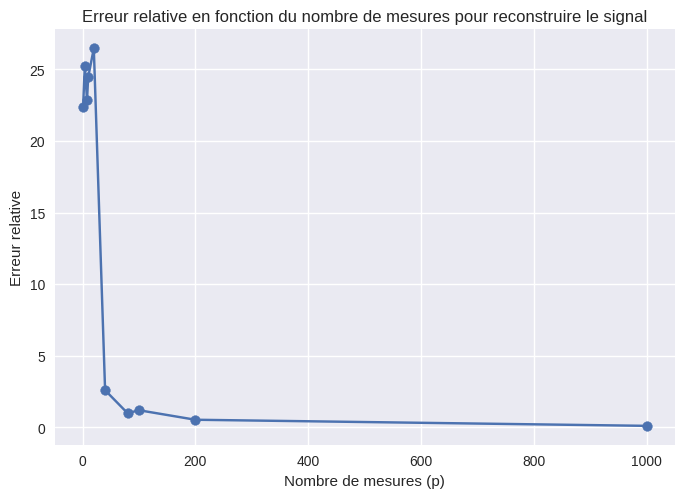

In [56]:
testData = [1,4,8,10,20,40,80,100,200,1000] # Valeurs de nombre de mesures (p) à tester
diff = testReco(testData,n,A,0.1,3000,1e-5,x)

Ce graphe ne nous donne qu'une indication concernant l'influence du nombre de mesure car il y a de l'aléa dans chaque test introduit par la matrice A. 
On peut cependant discener une forte décroissance de l'erreur relative entre 4 et environ 25 mesures. A partir de 50 mesures, le gain en erreur n'est plus aussi significatif. 

In [89]:
def recoNester(p,x):
    A=np.random.randn(p,n) #La matrice de mesure
    y=A.dot(x)        #Les mesures
    (alpha,xtilde,CF,err_loc) = Nesterov(A,y,0.1,2000,1e-5)
    fig,ax = plt.subplots(1,2,figsize=(20,8))

    ax[0].plot(xtilde)
    ax[0].set_title("Signal reconstruit avec " + str(p) + " mesures de x")
    
    ax[1].plot(np.abs(x-xtilde))
    ax[1].set_title("|x - xtilde|")

    plt.tight_layout()
    plt.show()

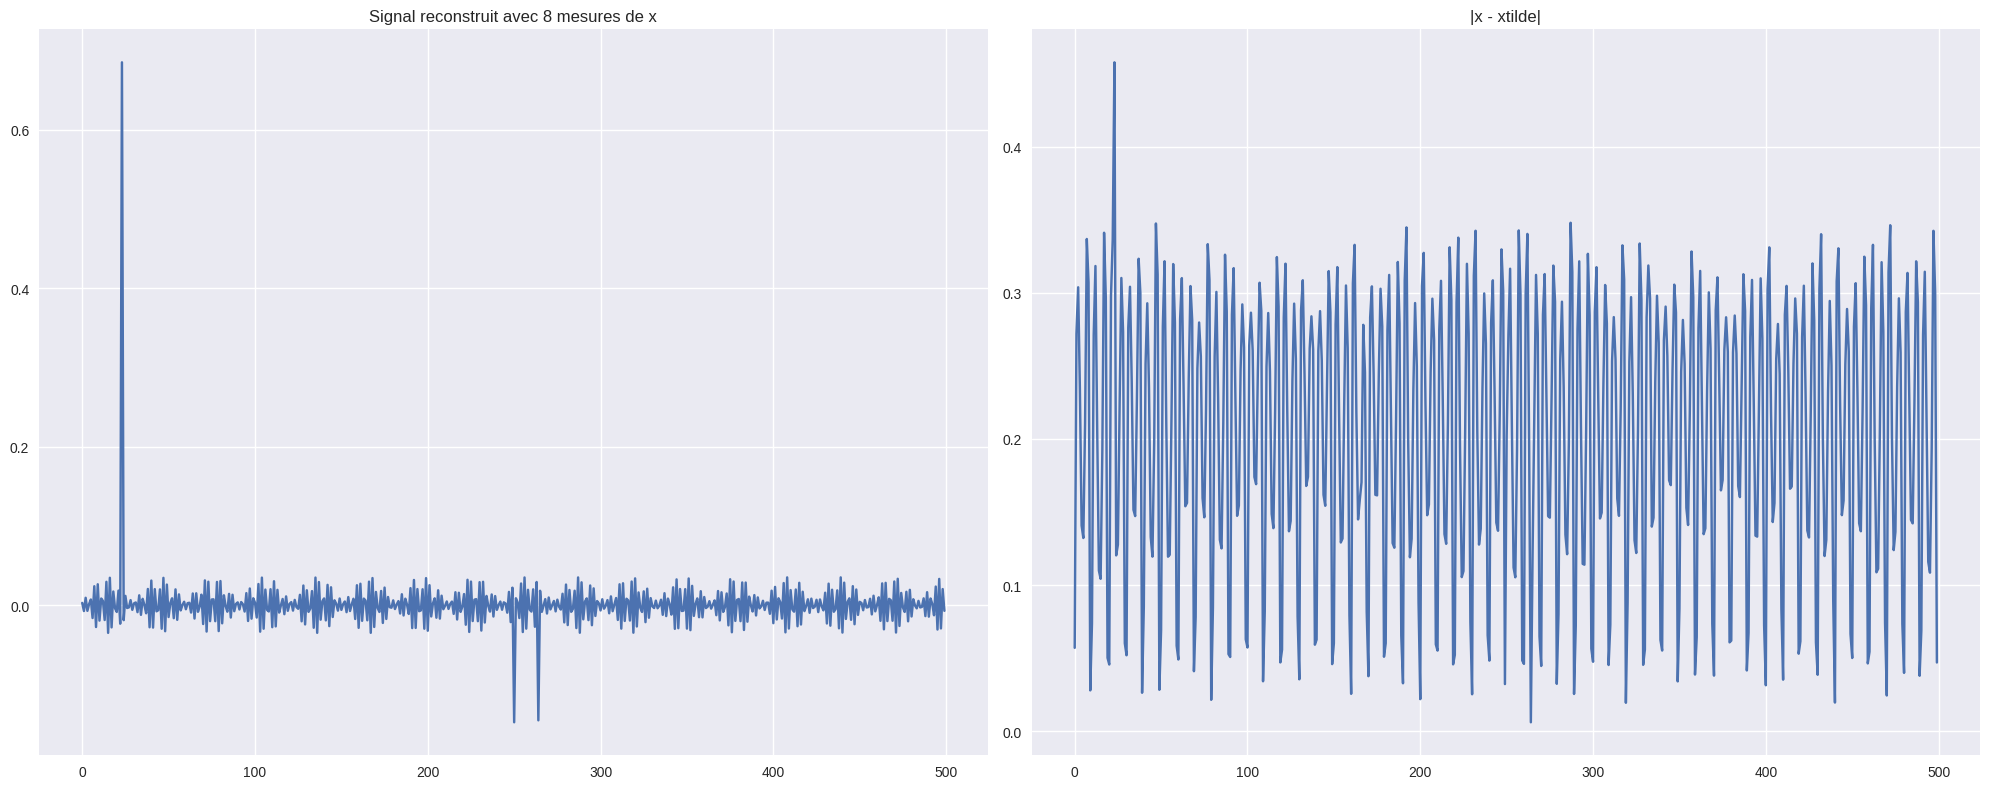

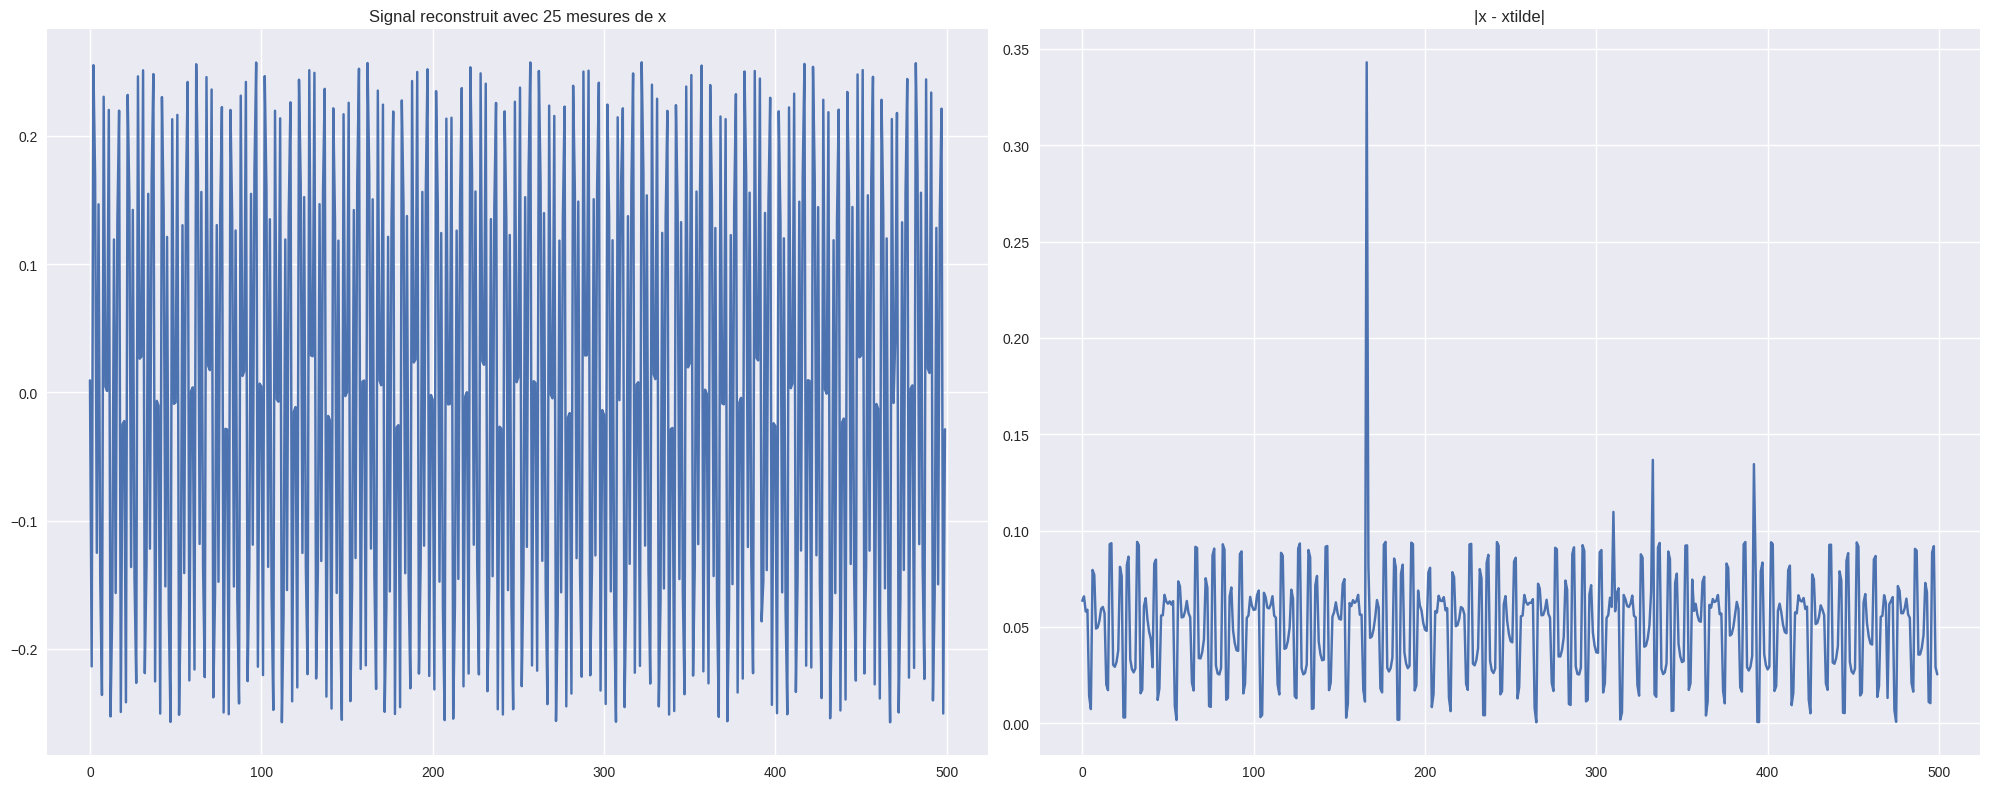

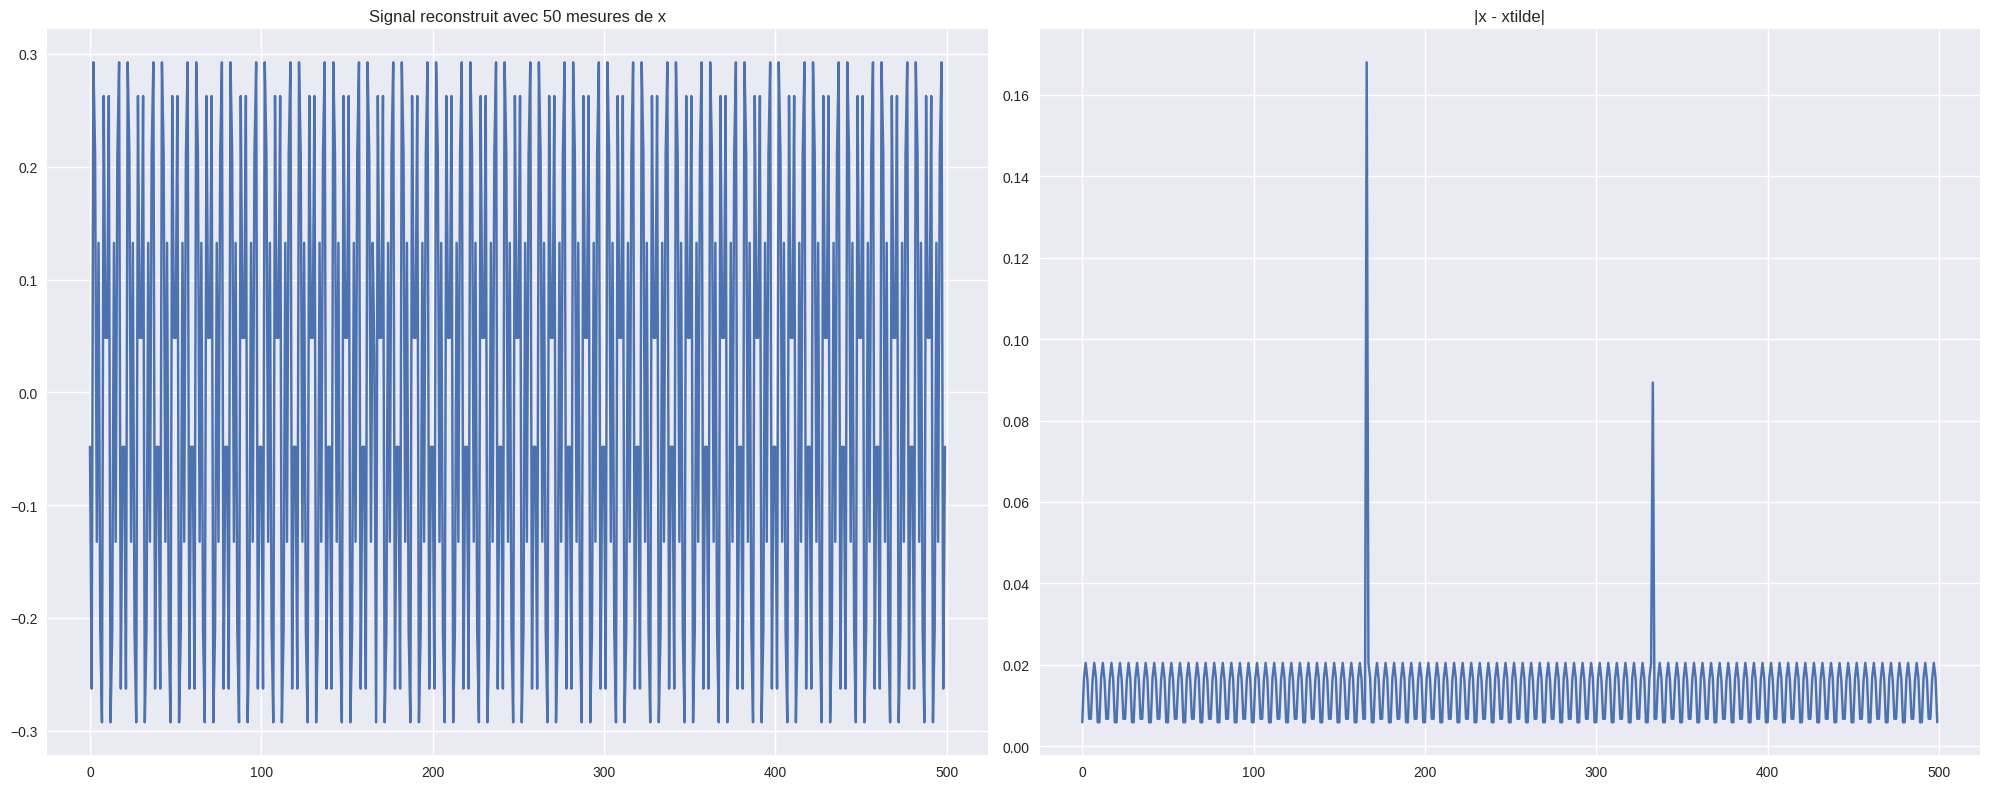

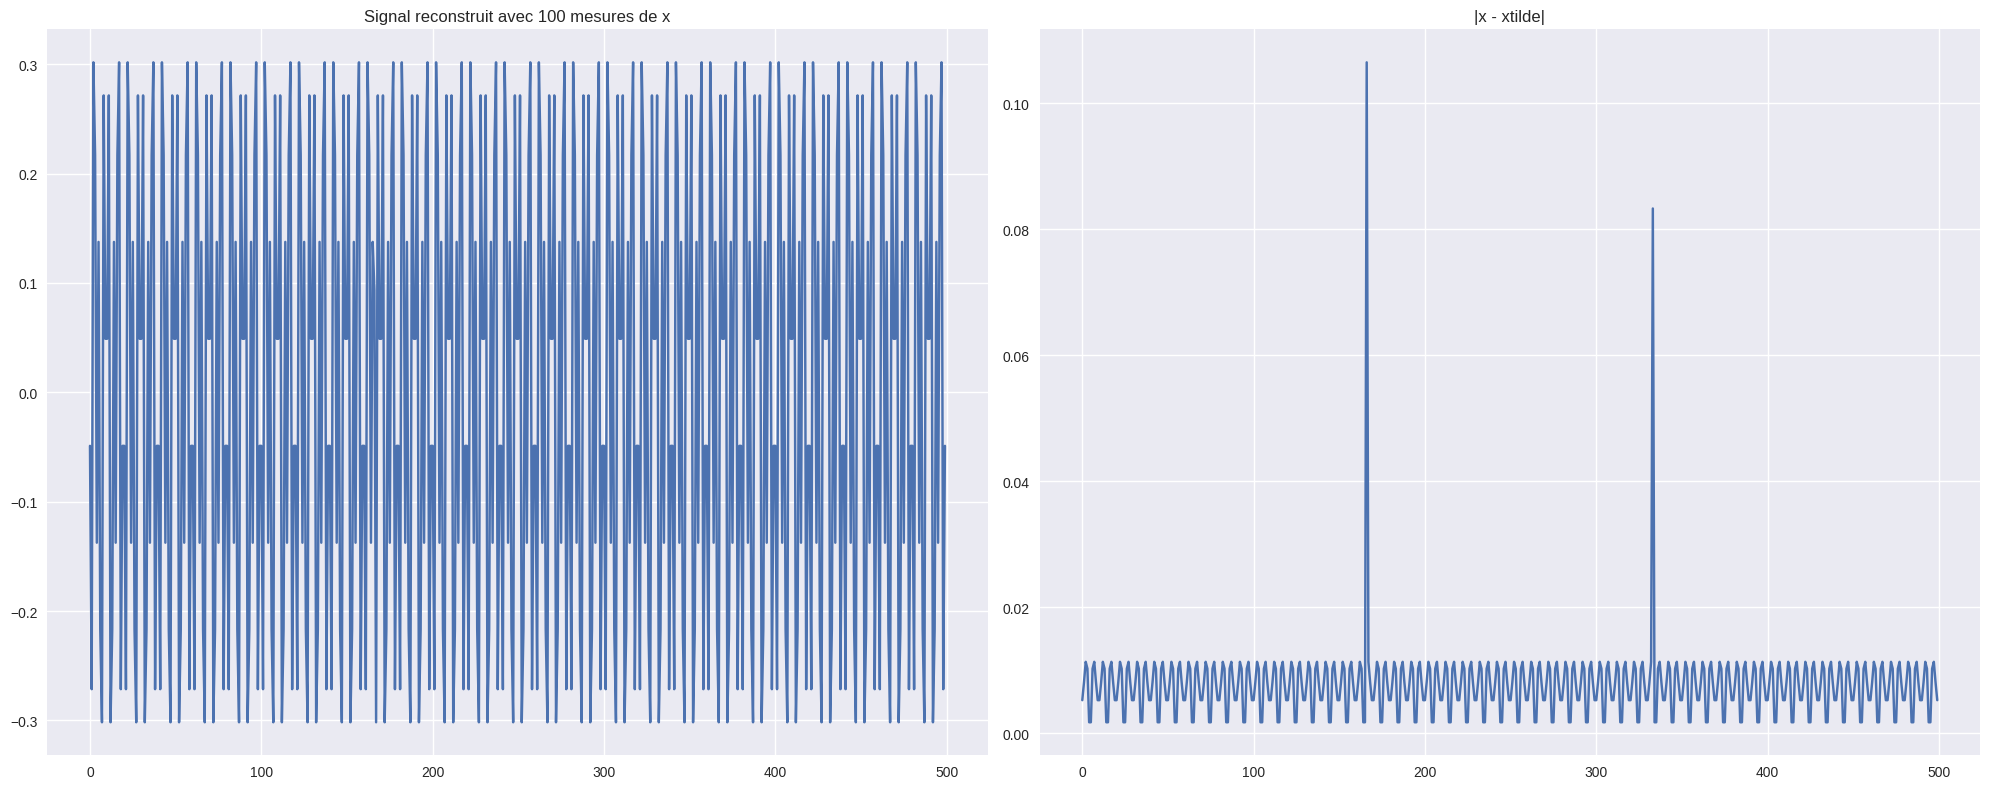

In [90]:
testData = [8,25,50,100]
for p in testData:
    recoNester(p,x)

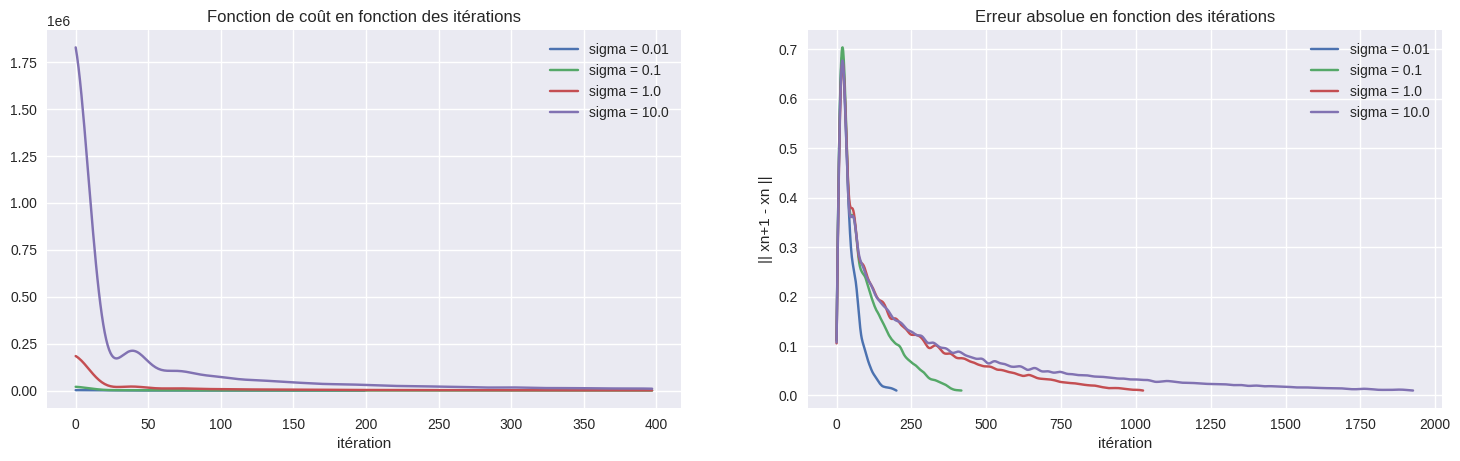

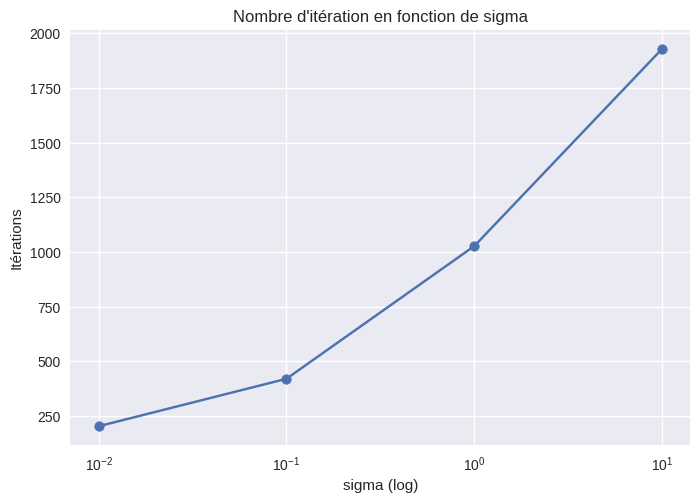

In [41]:
def bestSigma(nitermax):
    fig,ax = plt.subplots(1,2, figsize=(18,5))
    nit = [] # Tableau du nombre d'itérations par valeur du paramètre sigma
    testData = [10.**k for k in np.arange(-2,2,1)]
    for sigma in testData:
        (alpha,xtilde,CF,err)=Nesterov(A,y,sigma,nitermax,1e-2)
        nit.append(len(err))  

        im1 = ax[0].plot(CF[2:400],  label='sigma = ' + str(sigma))
        ax[0].set_title("Fonction de coût en fonction des itérations")
        ax[0].set_xlabel("itération")
        ax[1].set_ylabel("Fonction de coût")
        ax[0].legend()

        im2 = ax[1].plot(err[2:],  label='sigma = ' + str(sigma))
        ax[1].set_title("Erreur absolue en fonction des itérations")
        ax[1].set_xlabel("itération")
        ax[1].set_ylabel("|| xn+1 - xn ||")

        ax[1].legend()

    plt.show()

    plt.plot(testData,nit)
    plt.scatter(testData,nit)
    plt.xscale("log")
    plt.xlabel("sigma (log)")
    plt.ylabel("Itérations")
    plt.title("Nombre d'itération en fonction de sigma")
    plt.show()

In [96]:
def compareSpeed(nitermax):
    sigma = 0.1
    (alpha0, x0, CF0,err0) = Nesterov(A,y,sigma,nitermax, 1e-16)
    (alpha1, x1, CF1,err1) = RestoreX(A,y,sigma,nitermax, 1e-16)
    fig,ax = plt.subplots(1,2, figsize=(18,5))
    ax[0].plot(CF0[2:],  label='Nesterov')
    ax[0].plot(CF1[2:],  label='Pas nesterov')
    ax[0].set_title("Fonction de coût en fonction du nombre d'itérations ")
    ax[0].set_xlabel("Itération")
    ax[0].set_ylabel("Fonction de coût")
    ax[0].legend()


    nit = len(err0)
    ax[1].plot(CF0[2:], label="Nesterov")
    ax[1].plot(CF1[2:], label="RestoreX")
    ax[1].set_title("Fonction de coût (log) en fonction du nombre d'itérations ")
    ax[1].set_xlabel("Itération")
    ax[1].set_ylabel("Fonction de coût (log)")
    ax[1].legend()
    ax[1].set_yscale("log")

compareSpeed(3000)

**Q13.** Faites un rapide résumé des points qui vous ont semblé les plus importants dans ce TP.